Gruppenprojekt Gruppe 2

In [75]:
# imports
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import math

In [76]:
files_names = ["files/Bewertungsmatrix_Szenario1.csv","files/ItemProfile_Szenario1.csv","files/Ratings_Szenario1.csv", "files/Testdaten_Szenario1.csv"]

for s in files_names:
    text = open(s, "r")
    text = text.read()
    text = ''.join([i for i in text]) \
        .replace("\"", "")
    x = open(s,"w")
    x.writelines(text)
    x.close()

evaluation_matrix = pd.read_csv("files/Bewertungsmatrix_Szenario1.csv")
item_profiles = pd.read_csv("files/ItemProfile_Szenario1.csv", index_col='rowID')
ratings = pd.read_csv("files/Ratings_Szenario1.csv")
test_data = pd.read_csv("files/Testdaten_Szenario1.csv")

In [77]:
evaluation_matrix = evaluation_matrix.set_index('rowID')
#evaluation_matrix.head()
#user_df = pd.DataFrame(evaluation_matrix, index=['_0973_LasVegasGunRangeFirearms'])
#user_df.head()
#NearestNeighbors().info()

#test_data = test_data.set_index('User')
#evaluation_matrix['_0415_TheGrandCanalShoppes\"\"']
item_profiles.head()

,NLasVegas,SpringValley,NorthLasVegas,Paradise,LasVegas,Henderson,IT Services & Computer Repair,Drugstores,Gun/Rifle Ranges,Pawn Shops,...,Good For_breakfast,Good For_brunch,Parking_garage,Parking_street,Parking_validated,Parking_lot,Parking_valet,By Appointment Only,Good For Kids,Good For Groups
rowID,,,,,,,,,,,,,,,,,,,,,
_0820_RossDressforLess,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,NaN,NaN,NaN,NaN
_0569_BLShoeLuggageRepair,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,NaN,NaN,NaN,NaN
_0668_CVSpharmacy,0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,NaN,NaN,NaN,NaN
_1049_Albertsons,0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,NaN,NaN,NaN,NaN
_1097_CoachOutletStore,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,NaN,NaN,NaN,NaN


In [78]:
k = 2
# Weight for user-based predictions, (1 - alpha) will be the weight for item-based predictions
alpha = [0] * len(test_data.values)  

# Ensure evaluation_matrix is a DataFrame
evaluation_matrix = pd.DataFrame(evaluation_matrix)

"""def user_based_prediction(eval_matrix, user, item, k):
    user_df = pd.DataFrame(eval_matrix, index=[user])
    item_df = pd.DataFrame(eval_matrix, columns=[item])
    
    relevant_users_df = eval_matrix[eval_matrix[item] > 0.0]
    relevant_users_df = pd.concat([user_df, relevant_users_df])
    relevant_users_df = relevant_users_df.where(pd.notnull(relevant_users_df), 0.0)
    
    knn = NearestNeighbors(metric='euclidean', algorithm='auto')
    knn.fit(relevant_users_df.values)
    distances, indices = knn.kneighbors(relevant_users_df.values, n_neighbors=k+1)
    
    similar_user_distances = distances[0, 1:]
    similar_user_indices = indices[0, 1:]
    similar_user_ratings_df = pd.DataFrame(item_df, relevant_users_df.index[similar_user_indices])
    return similar_user_ratings_df.values.item(0)"""

def normalize_ratings(ratings):
    """Normalize ratings by subtracting the mean rating for each user."""
    return ratings.subtract(ratings.mean(axis=1), axis=0)

def user_based_prediction(eval_matrix, user, item, k):
    user_df = pd.DataFrame(eval_matrix, index=[user])
    item_df = pd.DataFrame(eval_matrix, columns=[item])
    
    relevant_users_df = eval_matrix[eval_matrix[item] > 0.0]
    relevant_users_df = pd.concat([user_df, relevant_users_df])
    relevant_users_df = relevant_users_df.where(pd.notnull(relevant_users_df), 0.0)
    relevant_users_df = normalize_ratings(relevant_users_df).fillna(0.0)

    # Find users who rated the target item
    #users_who_rated_item = normalized_matrix[item].dropna().index
    #relevant_users_df = normalized_matrix.loc[users_who_rated_item]
    #print(relevant_users_df.values)

    # Fit NearestNeighbors model with cosine similarity
    knn = NearestNeighbors(metric='cosine', algorithm='auto')
    knn.fit(relevant_users_df.values)
    distances, indices = knn.kneighbors(relevant_users_df.values, n_neighbors=k+1)
    
    similar_user_distances = distances[0, 1:]
    similar_user_indices = indices[0, 1:]

    # Calculate weighted average of ratings
    similar_user_ratings = eval_matrix.loc[relevant_users_df.index[similar_user_indices], item]
    weighted_sum = np.dot(similar_user_ratings, 1 - similar_user_distances)
    sum_of_weights = np.sum(1 - similar_user_distances)

    if sum_of_weights == 0:
        return np.nan

    return weighted_sum / sum_of_weights

def item_based_prediction(eval_matrix, user, item, k, count):
    item_df = pd.DataFrame(eval_matrix, columns=[item])
    user_df = pd.DataFrame(eval_matrix, index=[user])
    
    # Transpose the evaluation matrix for item-based filtering
    eval_matrix_transposed = eval_matrix.T

    if user not in eval_matrix_transposed.columns:
        return np.nan

    relevant_items_df = eval_matrix_transposed[eval_matrix_transposed[user] > 0.0]

    if relevant_items_df.empty:
        return np.nan
    if item in item_profiles.index:
        item_profile = item_profiles.loc[item]
        #similar_profiles = item_profiles[item_profiles.apply(lambda x: np.dot(x, item_profile) > 0, axis=1)]
        similar_profiles = item_profiles[item_profiles.apply(lambda x: np.sum(x != item_profile) <=12, axis=1)]
        #print(len(similar_profiles))
        relevant_items_df2 = relevant_items_df[relevant_items_df.index.isin(similar_profiles.index)]
    else:
        return np.nan
    
    alpha[count] = len(relevant_items_df2)
    #print(alpha[count])
    if len(relevant_items_df2.values) > 1:
        relevant_items_df = relevant_items_df2
        
    relevant_items_df = pd.concat([item_df.T, relevant_items_df])
    relevant_items_df = relevant_items_df.where(pd.notnull(relevant_items_df), 0.0)
    
    relevant_items_df = normalize_ratings(relevant_items_df)

    knn = NearestNeighbors(metric='cosine', algorithm='auto')
    knn.fit(relevant_items_df.values)
    distances, indices = knn.kneighbors(relevant_items_df.values, n_neighbors=k + 1)

    similar_item_distances = distances[0, 1:]
    similar_item_indices = indices[0, 1:]
    similar_items = relevant_items_df.index[similar_item_indices]

    similar_item_ratings = eval_matrix.loc[user, similar_items]
    
    weighted_sum = np.dot(similar_item_ratings, 1 - similar_item_distances)
    sum_of_weights = np.sum(1 - similar_item_distances)

    if sum_of_weights == 0:
        return np.nan

    return weighted_sum / sum_of_weights
    '''if not similar_item_ratings.empty:
        return similar_item_ratings.mean()
    else:
        return np.nan'''
    
    similar_user_ratings = eval_matrix.loc[relevant_users_df.index[similar_user_indices], item]
    weighted_sum = np.dot(similar_user_ratings, 1 - similar_user_distances)
    sum_of_weights = np.sum(1 - similar_user_distances)

    if sum_of_weights == 0:
        return np.nan

    return weighted_sum / sum_of_weights

# Ensure test_data is a DataFrame
test_data = pd.DataFrame(test_data)

# Update the evaluation matrix with combined predictions
count = 0
for index, row in test_data.iterrows():
    item = row['Item']
    user = row['User']
    
    if item not in evaluation_matrix.columns or user not in evaluation_matrix.index:
        continue  # Skip if the item or user is not in the evaluation matrix
    
    # Get user-based prediction
    user_pred = user_based_prediction(evaluation_matrix, user, item, k)

    # Get item-based prediction
    item_pred = item_based_prediction(evaluation_matrix, user, item, k, count)
    
    # Combine predictions with weighted average
    a = min(alpha[count]*0.2, 0.6)
    '''if alpha[count] == 0 or alpha[count] > 3:
        a = 0
    else:
        a = min(1/(alpha[count]), 1)'''
    print(alpha[count])
    count = count + 1
    if not np.isnan(user_pred) and not np.isnan(item_pred):
        combined_pred = (1-a) * user_pred + a * item_pred
        #combined_pred = 0 * user_pred + 1 * item_pred 
    elif not np.isnan(user_pred):
        combined_pred = user_pred
    elif not np.isnan(item_pred):
        combined_pred = item_pred
    else:
        combined_pred = np.nan


    # Update the evaluation matrix with the combined prediction
    evaluation_matrix.at[user, item] = np.round(combined_pred)
    print(user_pred, item_pred, combined_pred)
# Handle any potential NaN values if necessary (e.g., fill with a default value or drop)
evaluation_matrix = evaluation_matrix.fillna(0.0)

            

6
4.576201399214922 3.7045659772796053 4.053220146053732
9
3.9775444918228793 2.4890898618984334 3.084471713868212
14
4.509722086968592 2.9999999999999996 3.603888834787437
0
5.596684266268673 4.042878404461685 5.596684266268673
5
4.498569755008357 3.353801169590645 3.8117086037577295
5
4.414374280210539 3.0 3.5657497120842154
5
3.570465928753789 5.0 4.428186371501516
4
4.081179189730717 2.491419199943638 3.1273231958584695
87
3.0 4.0 3.6
77
3.0 4.0 3.6
6
2.433789516310996 2.0870793165119212 2.2257633964315513
18
4.670977508791074 4.54641219479925 4.59623832039598
4
4.061269001199114 4.35701743412959 4.2387180609574
42
2.509060218300747 2.9999999999999996 2.8036240873202987
50
3.5452984524932676 2.501988302191724 2.9193123623123416
5
2.9702039476999014 2.3574834948664223 2.6025716759998136
4
4.0 3.858788919173145 3.915273351503887
4
2.1515224200877086 3.0 2.660608968035083
8
4.0 4.0 4.0
8
4.0 3.452562640100105 3.671537584060063
9
4.426272945101802 2.9999999999999996 3.5705091780407203


In [79]:
#for index, row in test_data.iterrows():
#    print(evaluation_matrix.at[row['User'], row['Item']])
#evaluation_matrix.head()

0.0 6
0.0 9
2.0 14
1.0 0
0.0 5
1.0 5
0.0 5
-1.0 4
0.0 87
1.0 77
-1.0 6
1.0 18
0.0 4
0.0 42
-1.0 50
0.0 5
1.0 4
-1.0 4
0.0 8
1.0 8
1.0 9
0.0 0
2.0 3
-1.0 5
0.0 12
1.5 3
-3.0 6
1.0 4
-1.0 6
-1.0 16
0.0 20
1.0 8
1.0 3
2.0 6
2.0 5
-1.0 9
-1.0 5
-1.0 4
0.0 10
0.0 4
0.0 8
-1.0 4
-1.0 7
2.0 7
1.0 4
0.0 3
1.0 5
1.0 4
-1.0 7
1.0 3
0.0 15
-1.0 2
1.0 29
0.0 22
-2.0 25
0.0 12
-2.0 5
0.0 6
2.0 10
2.0 14
0.0 5
2.0 9
-1.0 0
1.0 2
-1.0 6
1.0 13
-1.0 22
0.0 26
1.0 8
0.0 10
1.0 4
0.0 3
-1.0 3
0.0 1
1.0 9
-1.0 11
2.0 11
0.0 6
-1.0 5
2.0 7
-2.0 4
1.0 3
0.0 5
0.0 4
0.0 4
-2.0 11
-2.0 11
-1.0 2
-1.0 13
0.0 22
2.0 4
0.0 5
-1.0 6
-1.0 61
2.0 4
0.0 10
0.0 7
-1.0 25
0.0 4
1.0 5
0.095
1.1236102527122116


C:\Users\ergoz\AppData\Local\Temp\ipykernel_2904\1557067237.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  bplt.show()
C:\Users\ergoz\AppData\Local\Temp\ipykernel_2904\1557067237.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  histogram.show()
C:\Users\ergoz\AppData\Local\Temp\ipykernel_2904\1557067237.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plotp.show()


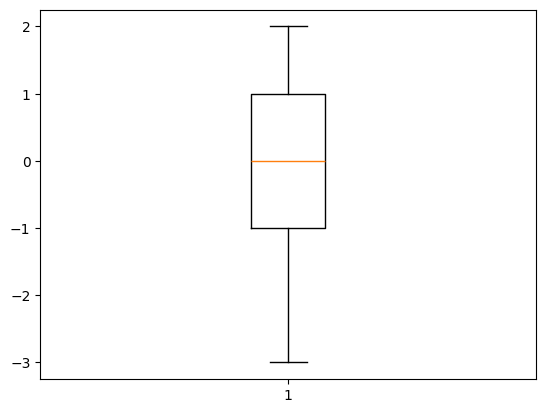

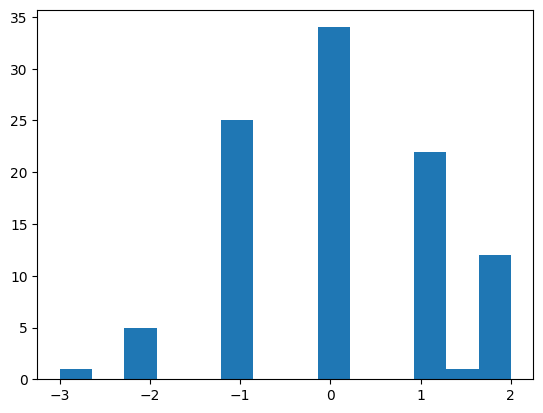

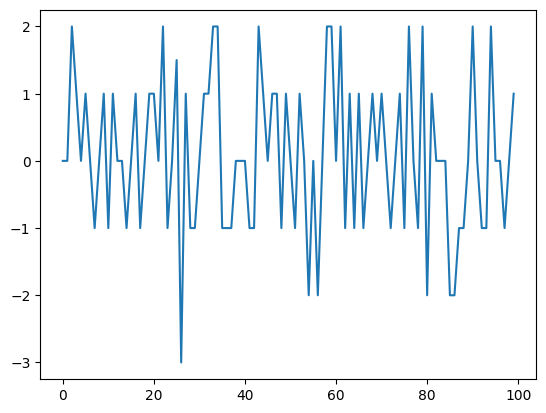

In [80]:
sum = 0
var = 0
data = []
counter = 0
for index, row in test_data.iterrows():
    item = row['Item']
    user = row['User']
    rating = row['Bewertung']
    data.append(evaluation_matrix.at[row['User'], row['Item']]-rating)
    print(evaluation_matrix.at[row['User'], row['Item']]-rating, alpha[counter])
    sum += evaluation_matrix.at[row['User'], row['Item']]-rating
    var += pow(evaluation_matrix.at[row['User'], row['Item']]-rating, 2)
    counter += 1
avg = sum/len(test_data.values)
var = np.sqrt(var/len(test_data.values))

# plot boxplot
bplt = plt.figure(1)
plt.boxplot(data)
bplt.show() 

# plot hist
histogram = plt.figure(2)
plt.hist(data, 14)
histogram.show()

plotp = plt.figure(3)
plt.plot(data)
plotp.show()


print(avg)
print(var)

In [81]:
evaluation_matrix.to_csv("out/result_matrix.csv")
print(pd.read_csv("out/result_matrix.csv"))

               rowID  _0400_MeadowsMall  _0583_AlternateRealityComics  \
0    _0039_Christina                3.0                           5.0   
1         _0059_Mark                0.0                           0.0   
2      _0086_Tetsuro                0.0                           0.0   
3        _0123_Anita                0.0                           0.0   
4         _0134_Kent                0.0                           0.0   
..               ...                ...                           ...   
595       _9877_Matt                0.0                           0.0   
596      _9885_Jemia                0.0                           0.0   
597       _9943_Ryan                0.0                           0.0   
598      _9958_Diana                0.0                           0.0   
599   _9984_Adrienne                0.0                           0.0   

     _0673_TargetGreatland  _0716_Walmart  _1085_Target  _1626_HobbyLobby  \
0                      4.0            3.0     